In [30]:
"""
Exp08: Out-of-sample testing

Goal:
- Test if the strategy generalizes to unseen data by selecting parameters on a training period and evaluating performance on a test period


Fixed:
- Asset: SPY
- Execution: EXEC_DELAY = 1
- Risk: none (vol_targeting / risk-off gate: off)


Sweep: Train & Test
Train: 2015-01-02 ~ 2021-12-31
Test (OOS): 2022-01-04 ~ 2024-12-31（或到你数据最后一天）

"""

'\nExp08: Out-of sample testing\n\nGoal:\n- Test how much capital can this strategy realistically deploy under realistic execution conditions?how transaction costs erode performance and identify the break-even cost level.\n\n把 COST_RATE 视为资本规模的 proxy\n即：更大的资金规模 ⇒ 更高的 effective transaction cost\n\n\nFixed:\n- Asset: SPY\n- Execution: EXEC_DELAY = 1\n- Risk: none (vol_targeting / risk-off gate: off)\n- regime\n\nSweep: Train & Test\nTrain: 2015-01-02 ~ 2020-12-31\nTest (OOS): 2021-01-04 ~ 2024-12-31（或到你数据最后一天）\n\n'

In [31]:
import os
os.chdir("/Users/kim/Desktop/Quant-Research")
print(os.getcwd())

# os.chdir("..")
# print(os.getcwd())

/Users/kim/Desktop/Quant-Research


In [32]:
import pandas as pd

from config import Config
from runner import run

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import replace
from config import Config

TRAIN_START, TRAIN_END = "2015-01-02", "2021-12-31"
TEST_START,  TEST_END  = "2022-01-04", "2024-12-31"  

cfg_base = replace(
    Config(),
    RISK_MODE="none",
    USE_RISK_OFF_GATE=False,
    EXEC_DELAY=1,
)

MA_CAND = [60, 80, 100, 120, 140]

# ---- 1) Train sweep ----
rows = []
for w in MA_CAND:
    cfg = replace(cfg_base, MA_WINDOW=w,START=TRAIN_START, END=TRAIN_END)
    _, summ = run(cfg)
    rows.append({"MA_WINDOW": w, **summ})

train_tbl = pd.DataFrame(rows).sort_values("MA_WINDOW")
display(train_tbl)

# 选 MA：最简单先选 Train Sharpe 最大
best_w = int(train_tbl.loc[train_tbl["Sharpe"].idxmax(), "MA_WINDOW"])
print("Selected MA (train-only):", best_w)


# ---- 2) OOS test ----
cfg_oos = replace(cfg_base, MA_WINDOW=best_w, START=TEST_START, END=TEST_END)
_, oos_summ = run(cfg_oos)
print("OOS summary:", oos_summ)

/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  idx = pd.to_datetime(df.index, errors="coerce")
/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed in

,MA_WINDOW,Annual Return,Max Drawdown,Sharpe,Total Turnover,N_obs
0,60,0.054056,-0.173953,0.545608,110.0,1703
1,80,0.080301,-0.161138,0.759547,70.0,1683
2,100,0.083917,-0.174146,0.778430,72.0,1663
3,120,0.083904,-0.173423,0.759121,68.0,1643
4,140,0.076471,-0.237091,0.677511,54.0,1623


Selected MA (train-only): 100
OOS summary: {'Annual Return': 0.10419275658182192, 'Max Drawdown': -0.12515416525309242, 'Sharpe': 0.8983564736634222, 'Total Turnover': 21.0, 'N_obs': 652}


/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  idx = pd.to_datetime(df.index, errors="coerce")


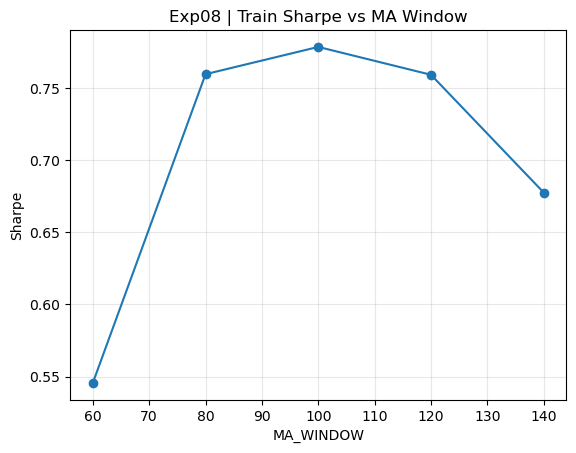

,Split,Sharpe,Annual Return,Max Drawdown,Total Turnover
0,Train,0.778430,0.083917,-0.174146,72.0
1,OOS,0.898356,0.104193,-0.125154,21.0


In [34]:

# ---- 3) Plot: Train Sharpe vs MA ----
ax = train_tbl.set_index("MA_WINDOW")["Sharpe"].plot(marker="o", title="Exp08 | Train Sharpe vs MA Window")
ax.set_xlabel("MA_WINDOW")
ax.set_ylabel("Sharpe")
ax.grid(True, alpha=0.3)
plt.show()

# ---- 4) Plot: Train vs OOS metrics (bar-like quick view) ----
comp = pd.DataFrame([
    {"Split": "Train", "Sharpe": train_tbl.loc[train_tbl["MA_WINDOW"]==best_w, "Sharpe"].iloc[0],
     "Annual Return": train_tbl.loc[train_tbl["MA_WINDOW"]==best_w, "Annual Return"].iloc[0],
     "Max Drawdown": train_tbl.loc[train_tbl["MA_WINDOW"]==best_w, "Max Drawdown"].iloc[0],
     "Total Turnover": train_tbl.loc[train_tbl["MA_WINDOW"]==best_w, "Total Turnover"].iloc[0]},
    {"Split": "OOS", **{k:oos_summ[k] for k in ["Sharpe","Annual Return","Max Drawdown","Total Turnover"]}}
])
display(comp)
